# Aprendizagem de Máquina I

## Hugo Tremonte de Carvalho

#### hugo@dme.ufrj.br

NOMES:
* ALUNO/A 1: Douglas Nery Barbosa

Este _notebook_ é correspondente ao nosso quarto projeto, passado no dia 14/11/2024 e para entrega no dia 12/12/2024. Ele consiste em resolver um problema prático. A entrega da atividade deve ser feita através do Google Classroom, fazendo um _upload_ deste _notebook_, devidamente atualizado com as suas resoluções e implementações. Recomendo fortemente que façam o trabalho no Google Colab, pois assim temos certa garantia de estarmos rodando tudo no mesmo ambiente e que eu conseguir executar o código de vocês sem dificuldades.

O projeto poderá ser feito **até** em dupla: quem quer fazer sozinho/a faz, mas quem quiser fazer em dupla também tem esse direito.

O objetivo deste trabalho é analisar [esta](https://www.kaggle.com/fmena14/volcanoesvenus) base de dados, que contém imagens de satélite da superfície de Vênus, e deseja-se estudar a ocorrência ou não de vulcões na superfície do planeta. A base de dados está contida no arquivo `dataset.zip`, anexo junto com essa atividade no Google Classroom, e mais abaixo irei detalhar os seus 4 arquivos.

In [ ]:
import numpy as np
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
path = kagglehub.dataset_download("fmena14/volcanoesvenus")
print("Path to dataset files:", path)

100%|██████████| 231M/231M [00:02<00:00, 85.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fmena14/volcanoesvenus/versions/1


Eis aqui o conjunto de treinamento. Você pode (e deve!) fazer validação cruzada nele para comparar diversos classificadores, mas o conjunto de teste será mostrado mais abaixo. Note que não há necessidade de fazer `train_test_split` com a base carregada a seguir, pois mais adiante carregaremos o arquivo com o conjunto de teste!

In [ ]:
import os
print(os.listdir('/root/.cache/kagglehub/datasets/fmena14/volcanoesvenus/versions/1'))

['volcanoes_train', 'volcanoes_test', 'Volcanoes_train', 'Volcanoes_test']


In [ ]:
feat = pd.read_csv(path + '/volcanoes_train/train_images.csv', header = None) # 'header = None' é importante pois o .csv não tem cabeçalho
resp = pd.read_csv(path + '/volcanoes_train/train_labels.csv')

display(feat)

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,...,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,90,96,88,95,94,100,95,80,80,71,...,88,83,72,76,73,79,76,79,84,69
6996,82,82,84,91,74,61,73,80,75,97,...,100,78,90,88,80,88,90,90,66,71
6997,133,102,121,133,129,131,98,121,123,125,...,120,123,119,111,104,102,119,130,131,111
6998,118,117,115,107,92,76,100,102,81,106,...,104,105,102,111,99,90,105,100,100,109


Cada linha do dataframe são os pixels de uma imagem em tons de cinza de tamanho 110 x 110, "achatados" em um vetor de tamanho 12.100.

Note que cada pixel corresponde a um valor inteiro entre 0 (totalmente preto) e 255 (totalmente branco). Talvez seja conveniente transformá-los em um número entre 0 e 1.

Vamos ver algumas das imagens na base de dados:

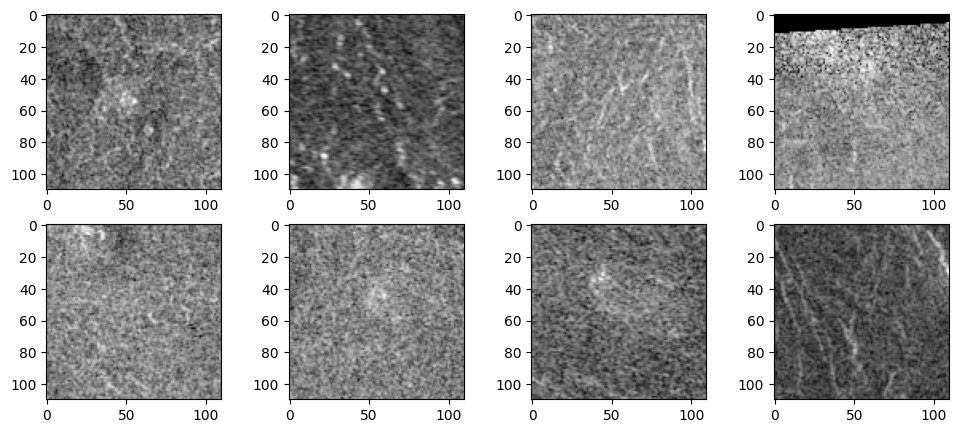

In [ ]:
fig, axs = plt.subplots(2, 4)
fig.set_size_inches(12, 5)
ind = 0

for ax in axs.flat:
    img = np.array(feat.iloc[ind]).reshape((110,110))
    ax.imshow(img, cmap = 'gray')
    ind += 1

Agora, vamos entender as variáveis resposta:

In [ ]:
resp.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


Eis o que cada informação na variável resposta significa:

 * Se ``Volcano? = 0``, então na respectiva imagem acredita-se fortemente que **não** há um vulcão
 * Se ``Volcano? = 1``, então acredita-se fortemente que naquela imagem há ao menos um vulcão, e nesse caso há informações adicionais:
   - ``Number Volcanoes`` representa quantos vulcões provavelmente há naquela imagem (nesse caso, há um vulcão centralizado na figura)
   - ``Radius`` é o raio do vulcão que está centralizado na imagem, medido em *pixels*
   - ``Type`` é uma variável que codifica a incerteza dos astrônomos sobre a existência de um vulcão naquela imagem:
     - ``Type = 1`` indica que a figura respectiva CERTAMENTE contém ao menos um vulcão
     - ``Type = 2`` indica que a figura respectiva PROVAVELMENTE contém ao menos um vulcão
     - ``Type = 3`` indica que a figura respectiva POSSIVELMENTE contém ao menos um vulcão
     - ``Type = 4`` indica que a figura respectiva mostra somente uma cratera

*Obs.: No caso de ``Volcano? = 0``, as outras variáveis são preenchidas com ``NaN``*

Note que a base de dados está desbalanceada.

Obs.: Gráfico de pizza só pra não perder a oportunidade de falar mal do gráfico de pizza e recomendar fortemente que vocês NÃO façam esse tipo de gráfico! :-)

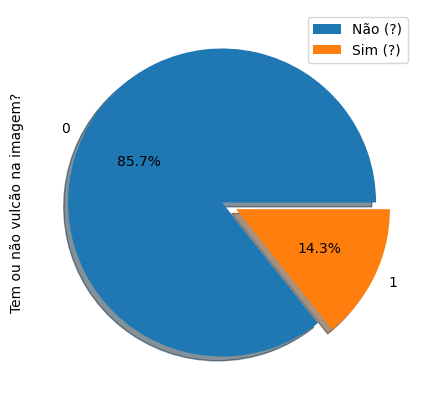

In [ ]:
resp['Volcano?'].value_counts().plot(
    kind = 'pie', explode = [0, 0.1], figsize = (5, 5), autopct = '%1.1f%%', shadow = True)
plt.ylabel('Tem ou não vulcão na imagem?')
plt.legend(['Não (?)', 'Sim (?)'])
plt.show()

Dentre as imagens que acredita-se ter um vulcão, vamos ver a distribuição dos quatro graus de incerteza possíveis:

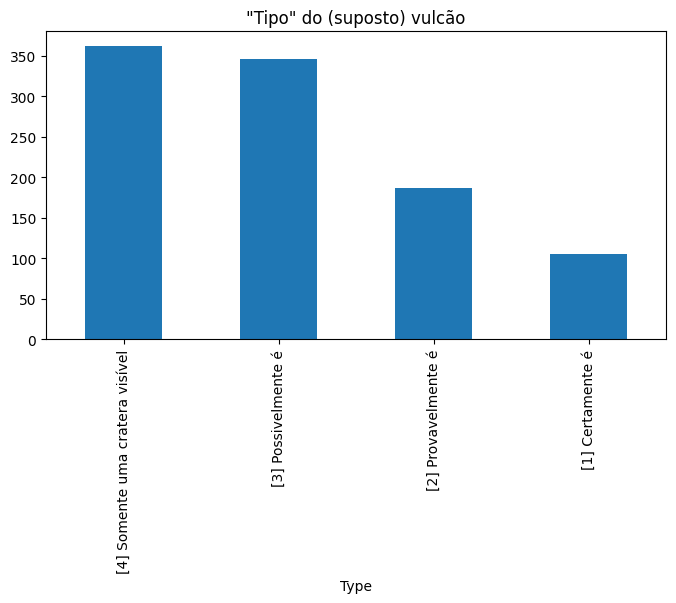

In [ ]:
resp[resp['Volcano?'] == 1]['Type'].value_counts().plot(kind = 'bar', legend = False, figsize = (8, 4))
plt.title('"Tipo" do (suposto) vulcão')
plt.xticks(np.arange(4), ['[4] Somente uma cratera visível', '[3] Possivelmente é', '[2] Provavelmente é', '[1] Certamente é'])
plt.show()

Temos uma variável resposta contínua, que é o raio do vulcão:

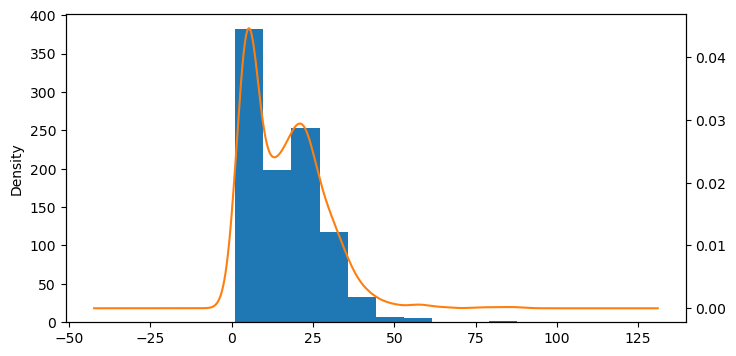

In [ ]:
ax = resp[resp['Volcano?'] == 1]['Radius'].plot(kind = 'hist', legend = False, figsize = (8, 4))
resp[resp['Volcano?'] == 1]['Radius'].plot(kind = 'kde', ax = ax, secondary_y = True)
plt.show()

Finalmente, estudando a quantidade suposta de vulcões na imagem:

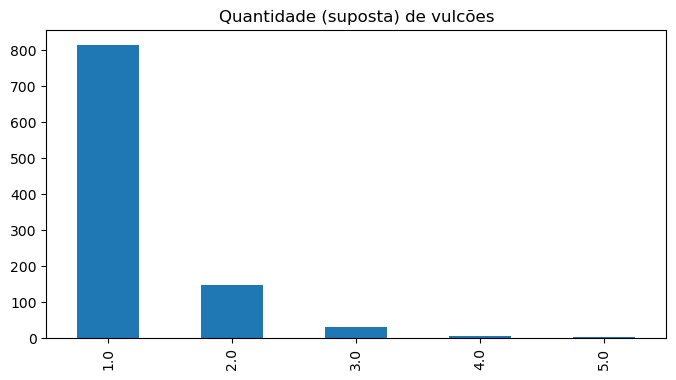

In [ ]:
plt.title('Quantidade (suposta) de vulcões')
resp[resp['Volcano?'] == 1]['Number Volcanoes'].value_counts().plot(kind = 'bar', legend = False, figsize = (8, 4))
plt.show()

Agora, vejamos alguns exemplos de imagens da base de dados com diversas das características vistas acima:

== IMAGEM SEM VULCÃO ==
Volcano?            0.0
Type                NaN
Radius              NaN
Number Volcanoes    NaN
Name: 1, dtype: float64


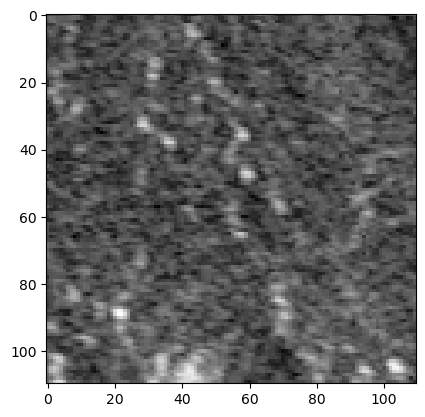

In [ ]:
print('== IMAGEM SEM VULCÃO ==')

print(resp.iloc[1])

image = np.array(feat.iloc[1]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 1.00
Radius              22.02
Number Volcanoes     1.00
Name: 9, dtype: float64


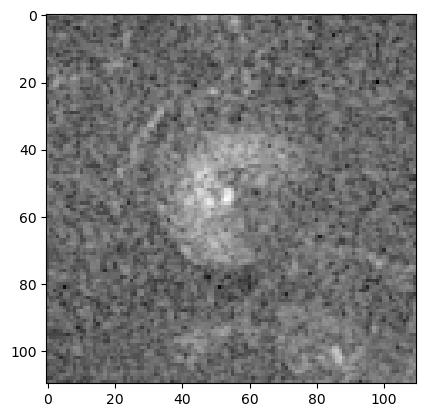

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[9])

image = np.array(feat.iloc[9]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 2.00
Radius              19.31
Number Volcanoes     1.00
Name: 38, dtype: float64


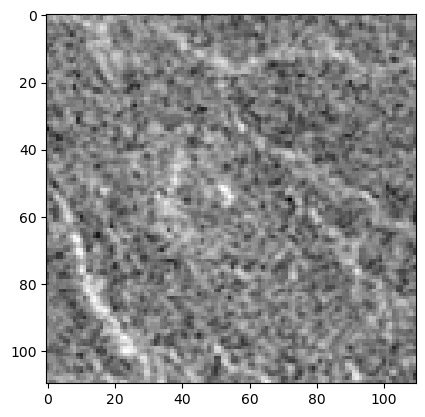

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[38])

image = np.array(feat.iloc[38]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 3.00
Radius              17.46
Number Volcanoes     1.00
Name: 0, dtype: float64


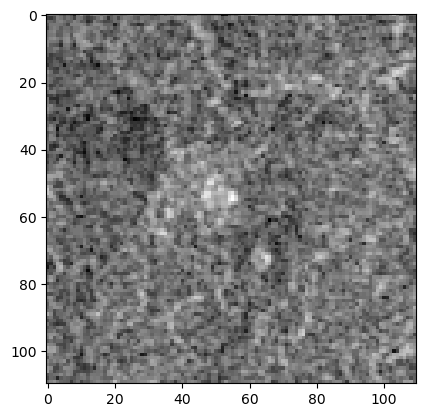

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[0])

image = np.array(feat.iloc[0]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?            1.0
Type                4.0
Radius              8.0
Number Volcanoes    2.0
Name: 55, dtype: float64


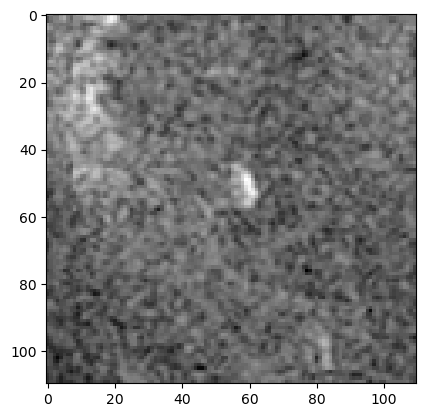

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[55])

image = np.array(feat.iloc[55]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 3.00
Radius              21.63
Number Volcanoes     2.00
Name: 34, dtype: float64


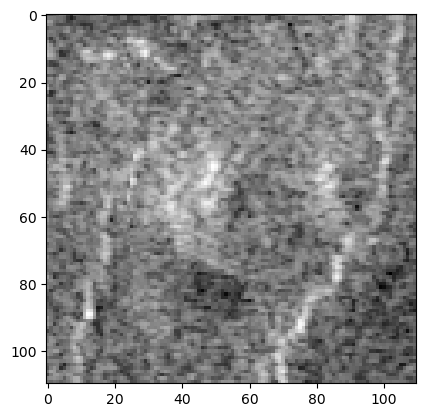

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[34])

image = np.array(feat.iloc[34]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 2.00
Radius              24.33
Number Volcanoes     3.00
Name: 596, dtype: float64


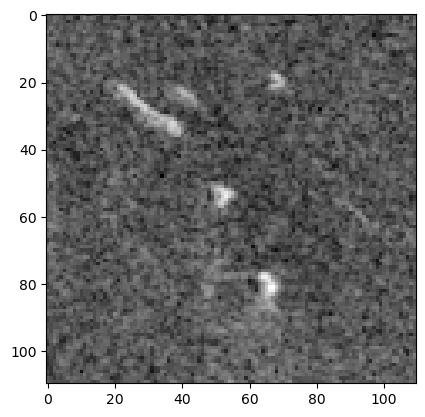

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[596])

image = np.array(feat.iloc[596]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?            1.00
Type                4.00
Radius              3.61
Number Volcanoes    4.00
Name: 425, dtype: float64


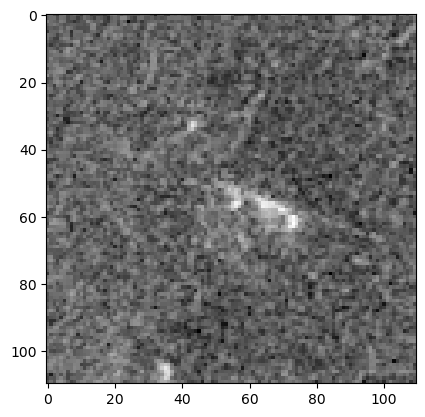

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[425])

image = np.array(feat.iloc[425]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

== IMAGEM COM VULCÃO ==
Volcano?            1.00
Type                3.00
Radius              5.83
Number Volcanoes    5.00
Name: 853, dtype: float64


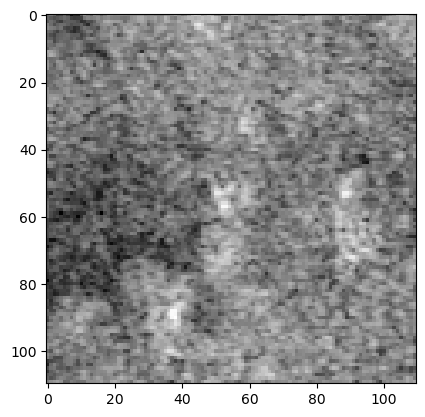

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[853])

image = np.array(feat.iloc[853]).reshape((110,110))
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()

## Objetivos

Os principais objetivos do projeto são:

1) Prever, **somente a partir da imagem**, se naquela foto há ou não um vulcão. Ou seja, deve ser resolvido o problema de **classificação binária** onde os dados observados são as linhas do DataFrame ``feat`` e a variável resposta é a coluna ``Volcano?`` do DataFrame ``resp``.

2) Prever, **somente a partir das imagens que têm ao menos um vulcão**, o raio do vulcão que está centralizado na figura. Ou seja, deve ser resolvido o problema de **regressão** onde os dados observados são as linhas do DataFrame `feat` para as quais a variável `Volcano?` é 1, e a variável resposta é a coluna `Radius` do DataFrame `resp`.

Para isso, você deverá testar todos os classificadores e regressores que aprendemos no curso (regressão linear simples, Lasso, Ridge, Naive Bayes, LDA, QDA, SVM, KNN e métodos baseados em árvores), otimizar os hiperparâmetros (quando pertinente) e escolher qual é o melhor classificador e regressor, utilizando o conjunto de treinamento. Finalmente, compare o desempenho de todos eles no conjunto de teste, e decida por um classificador e um regressor bons para esse problema.

Como de costume, o treinamento dos classificadores e a validação cruzada para otimização dos hiperparâmetros é um procedimento a ser realizado somente no conjunto de **treinamento**, já carregado. A performance dos melhores classificadores elencados deve ser aferida no conjunto de **teste**, carregado abaixo:

In [ ]:
feat_test = pd.read_csv(path + '/volcanoes_test/test_images.csv', header = None)
resp_test = pd.read_csv(path + '/volcanoes_test/test_labels.csv')

### Informações importantes

* Justifique se você deve tomar mais cuidado com falsos negativos ou falsos positivos no objetivo do projeto.


* Você deve entregar:
  - Um Notebook do Jupyter contendo os seus códigos.
  - Células de *markdown* neste notebook, na forma de um relatório, explicando o procedimento que te levou a tais classificadores, como se fosse um resumo de sua investigação. Entregar somente códigos sem explicação **não** é suficiente! Eu tenho que conseguir entender quais foram suas ideias e desenvolvimentos **somente a partir do texto**, sem ter que recorrer ao código. Isso é importante para vocês treinarem a escrita!


* Algumas observações:
  - Descreva o resultado que você obteve, e não somente mostre métricas sem justificativa.
  - A base de dados é **bastante** pesada: 7.000 observações de 12.100 atributos (olha o cenário $p > n$ aí!). Caso você opte por rodar localmente em sua máquina, dependendo da configuração dela, alguns algoritmos podem apanhar um pouco para finalizarem a sua execução. Eu não acredito que NB, LDA, QDA e KNN irão ser problemáticos, porém florestas aleatórias e especialmente o SVM costumam ser **bem** mais custoso do que os outros. No caso do SVM, proponho duas alternativas:
    - Em vez de usar o `SVC()`, que te dá a possibilidade de escolher o *kernel* de interesse, você pode usar o `SGDClassifier()`, que está alocado dentro do módulo `sklearn.linear_model` (veja [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) a sua documentação). Conforme está explicitado na documentação, esse classificador com o parâmtro `loss = 'hinge'` é equivalente ao SVM com *kernel* linear, porém com a vantagem de poder ser treinado em minilotes, reduzindo a questão do custo computacional. O seu lado negativo é que não há como escolher outros *kernel*, e você terá que estudar mais hiperparâmetros para serem ajustados, conforme também está explicitado na documentação.
    - Para usar o `SVC()` e testar outros *kernel* além do linear, se o processamento estiver muito pesado, você pode reduzir o tamanho da base de dados: em vez de considerar 7.000 imagens, você pode pegar, digamos, 2.000 imagens mas mantendo a proporção entre as classes positiva e negativa. Note que esse procedimento é feito **somente** para aliviar a questão computacional e conseguirmos finalizar o projeto em tempo finito! Em um cenário real, havendo poder computacional e tempo disponíveis, deve-se usar sempre todos os dados.
  - Caso você vá usar o Google Colab para fazer esse projeto, recomendo fortemente que carreguem a base de dados através de sincronização com o Google Drive. Só o conjunto de treinamento tem quase 300 Mb, e fazer *upload* disso sempre será meio chato; sem contar o fato de ter que fazer *upload* sempre que a conexão oscilar...


* A base de dados consiste das imagens cruas, ou seja, sem nenhum pré-processamento. Porém, acrescentar essa etapa pode melhorar **muito** os seus resultados. Portanto, é recomendada (e sugerida!) a utilização das ferramentas de "*Detection of features and objects*" e "*Filtering and restoration*", disponível no **scikit-image** (https://scikit-image.org/). Como esses procedimentos não "aprendem" nada com a base de dados, não há necessidade de fazerem parte do classificador através de uma `Pipeline`, e podem ser aplicados na base de treinamento e teste toda.

* Para essa tarefa uma ideia interessante é reduzir o tamanho da imagem! Como o vulcão está centralizado na figura, quando há ao menos um, não há necessidade de considerar a figura toda, mas talvez uma caixinha de tamanho $10 \times 10$ em torno do centro já seja suficiente. Assim, você reduzirá a quantidade de atributos de 12.100 para 100, provavelmente com pouco prejuízo para o desempenho da classificação. Porém, talvez isso atrapalhe o desempenho da regressão...

* É EXPRESSAMENTE PROIBIDO USAR REDES NEURAIS!!!! O motivo é que temos uma (ótima!) disciplina sobre o tema, então usemos as coisas em seu momento devido ;-)

In [ ]:
from skimage import exposure
from skimage.filters import gaussian
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay, confusion_matrix

## Pré-processamento

In [ ]:
print("X_train ->",feat.shape,"\ny_train ->",resp.shape,"\nX_test ->",feat_test.shape,"\ny_test ->",resp_test.shape)

X_train -> (7000, 12100) 
y_train -> (7000, 4) 
X_test -> (2734, 12100) 
y_test -> (2734, 4)


In [ ]:
feat.describe()

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.00000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,...,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000
mean,99.983857,99.980571,100.013429,99.974143,100.08000,100.171286,100.059571,100.187143,100.552286,100.494286,...,100.252714,100.528286,100.589286,100.386000,100.286429,100.332429,100.437286,100.492143,100.145857,100.032143
std,26.499896,26.414896,26.408002,26.439919,26.51432,26.512484,26.631280,26.506073,26.457947,26.677367,...,25.473316,25.447919,25.308967,25.185476,25.096433,25.303697,25.401405,25.313594,25.119432,25.175735
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,88.000000,88.000000,88.000000,88.000000,88.00000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
50%,101.000000,101.000000,101.000000,101.000000,101.00000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,100.000000,100.000000,101.000000,101.000000,100.000000,100.000000
75%,115.000000,115.000000,115.000000,115.000000,115.00000,115.000000,115.000000,115.000000,116.000000,115.000000,...,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,114.000000,114.000000
max,190.000000,186.000000,186.000000,188.000000,192.00000,191.000000,197.000000,202.000000,202.000000,196.000000,...,199.000000,190.000000,184.000000,180.000000,182.000000,177.000000,182.000000,185.000000,179.000000,181.000000


In [ ]:
resp.fillna(value=0,inplace=True)
resp_test.fillna(value=0,inplace=True)

In [ ]:
resp_sem_radius = resp.drop(['Radius','Type','Number Volcanoes'],axis=1)
resp_test_sem_radius = resp_test.drop(['Radius','Type','Number Volcanoes'],axis=1)

In [ ]:
def avaliar_regressao(modelo, y_teste, y_pred):
    r2 = r2_score(y_teste, y_pred)
    mae = mean_absolute_error(y_teste, y_pred)
    rmse = np.sqrt(mean_squared_error(y_teste, y_pred))

    print(f"\nAvaliação do Modelo:")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}\n")

def fill_radius(row, radius_values):
    if row['Volcano?'] == 1.0:
        return radius_values.pop(0)
    return 0.0

def validar_com_cross_val(modelo, X, y, cv=5, score=None):
    kfold = KFold(n_splits=cv, shuffle=True, random_state=5)
    scores = cross_val_score(modelo, X, y, cv=kfold, scoring=score)

    print(f"Validação Cruzada ({cv}-fold):")
    print(f"Scores: {scores}")

# Classificação

Aqui estou treinando e fazendo as previsões para cada classificador:
- DecisionTree
- NaiveBayes
- QDA
- LDA
- KNN
- SVM


In [ ]:
X_train_clsf = np.array(feat) ; y_train_clsf = np.array(resp_sem_radius)
X_test_clsf = np.array(feat_test) ; y_test_clsf = np.array(resp_test_sem_radius)

## DecisionTree

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train_clsf,y_train_clsf)

pred = clf.predict(X_test_clsf)
pred_df = pd.DataFrame(pred)

pred_df.columns = ['Volcano?']

print(pred_df.head())

   Volcano?
0         0
1         0
2         1
3         0
4         1


In [ ]:
acc = accuracy_score(y_test_clsf, pred)
print(f"Acurácia: {acc}")

Acurácia: 0.8840526700804682


In [ ]:
validar_com_cross_val(clf, X_train_clsf, y_train_clsf, cv=3);

Validação Cruzada (3-fold):
Scores: [0.88860326 0.88984141 0.88598371]


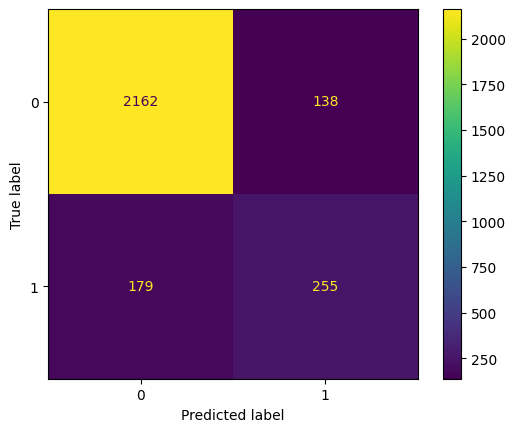

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_clsf, y_test_clsf)

### Resumo DecisionTree

O modelo apresenta uma boa acurácia com consistência no teste de validação cruzada. Já verificando a matrix de confusão é possível observar um problema com os falsos positivos sendo 40% das imagens com vulcão sendo classificadas como sem vulcão. Isso mostra que esse não é um modelo adequado que captura bem os verdadeiros positivos. Sobre os verdadeiros negativos, pela quantidade massiva de imagens sem vulcão, acaba sendo maior devido a isso.

## Naive Bayes

In [ ]:
clf1 = GaussianNB()
clf1.fit(X_train_clsf,y_train_clsf)

pred1 = clf1.predict(X_test_clsf)
pred_df = pd.DataFrame(pred1)

pred_df.columns = ['Volcano?']

print(pred_df.head())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Volcano?
0         1
1         1
2         1
3         1
4         1


In [ ]:
acc = accuracy_score(y_test_clsf, pred1)
print(f"Acurácia: {acc}")

Acurácia: 0.3357717629846379


In [ ]:
validar_com_cross_val(clf1, X_train_clsf, y_train_clsf, cv=3);

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validação Cruzada (3-fold):
Scores: [0.3243359  0.34076297 0.32447492]


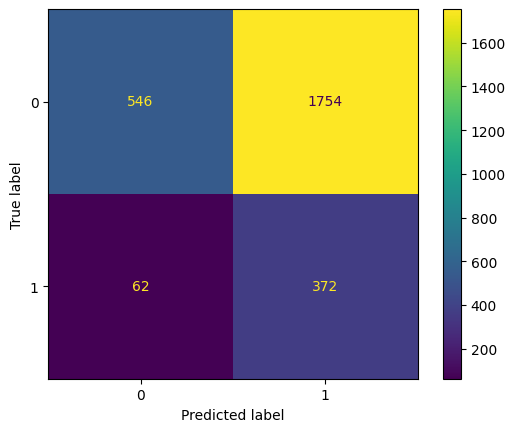

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf1, X_test_clsf, y_test_clsf)

### Resumo Naive Bayes

Apesar de ter uma acurácia menor em relação ao DecisionTree, obteve mais acertos em verdadeiros positivos. Porém ainda não é um bom modelo pois apresenta baixa acurácia e uma alta taxa de falsos negativos.

## QDA

In [ ]:
clf1 = QuadraticDiscriminantAnalysis()
clf1.fit(X_train_clsf,y_train_clsf);

pred1 = clf1.predict(X_test_clsf)

pred_df = pd.DataFrame(pred1)
pred_df.columns = ['Volcano?']

print(pred_df.head())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


   Volcano?
0         1
1         0
2         1
3         0
4         1


In [ ]:
acc = accuracy_score(y_test_clsf, pred1)
print(f"Acurácia: {acc}")

Acurácia: 0.8840526700804682


In [ ]:
validar_com_cross_val(clf1, X_train_clsf, y_train_clsf, cv=3);

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

Validação Cruzada (3-fold):
Scores: [0.51799486 0.49849979 0.51521646]


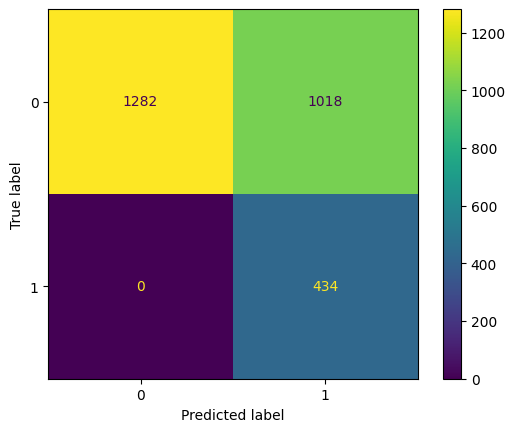

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf1, X_test_clsf, y_test_clsf)

### Resumo QDA

Modelo não adequado devido a baixa acurácia nos testes.

## LDA

In [ ]:
clf1 = LinearDiscriminantAnalysis()
clf1.fit(X_train_clsf,y_train_clsf);


pred1 = clf1.predict(X_test_clsf)

pred_df = pd.DataFrame(pred1)
pred_df.columns = ['Volcano?']

print(pred_df.head())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Volcano?
0         1
1         0
2         0
3         0
4         0


In [ ]:
acc = accuracy_score(y_test_clsf, pred1)
print(f"Acurácia: {acc}")

Acurácia: 0.8942940746159473


In [ ]:
validar_com_cross_val(clf1, X_train_clsf, y_train_clsf, cv=3);

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validação Cruzada (3-fold):
Scores: [0.90659811 0.8962709  0.91084441]


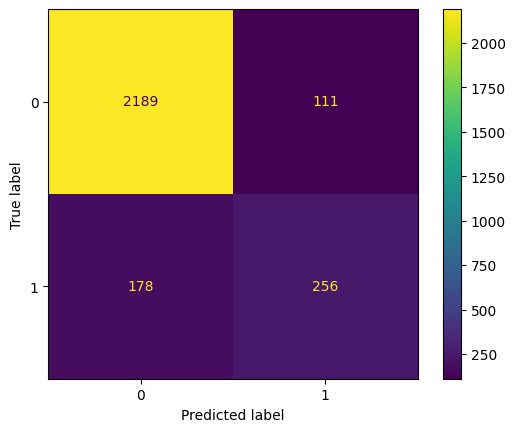

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf1, X_test_clsf, y_test_clsf)

### Resumo LDA

## KNN

In [ ]:
clf1 = KNeighborsClassifier()
clf1.fit(X_train_clsf,y_train_clsf);

pred1 = clf1.predict(X_test_clsf)

pred_df = pd.DataFrame(pred1)
pred_df.columns = ['Volcano?']

print(pred_df.head())

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


   Volcano?
0         0
1         0
2         1
3         0
4         0


In [ ]:
acc = accuracy_score(y_test_clsf, pred1)
print(f"Acurácia: {acc}")

Acurácia: 0.8423555230431602


In [ ]:
validar_com_cross_val(clf1, X_train_clsf, y_train_clsf, cv=3);

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Validação Cruzada (3-fold):
Scores: [0.85732648 0.85769396 0.86026575]


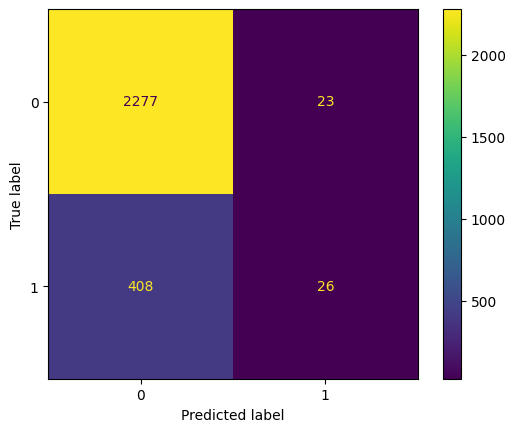

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf1, X_test_clsf, y_test_clsf)

### Resumo KNN

## SVM

In [ ]:
clf1 = SGDClassifier()
clf1.fit(X_train_clsf,y_train_clsf);

pred1 = clf1.predict(X_test_clsf)
pred_df = pd.DataFrame(pred1)

pred_df.columns = ['Volcano?']
print(pred_df.head())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


   Volcano?
0         1
1         0
2         1
3         0
4         1


In [ ]:
acc = accuracy_score(y_test_clsf, pred1)
print(f"Acurácia: {acc}")

Acurácia: 0.9257498171177762


In [ ]:
validar_com_cross_val(clf1, X_train_clsf, y_train_clsf, cv=3);

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validação Cruzada (3-fold):
Scores: [0.93144816 0.91984569 0.92713245]


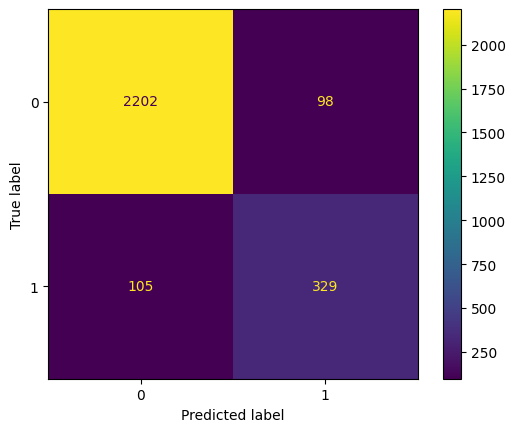

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf1, X_test_clsf, y_test_clsf)

### Resumo SVM

Apresentou uma boa acurácia seguido de uma constância na validação cruzada. Também performou bem no teste da matriz de confusão apresentando menos de 25% casos de falsos positivos. Dentre os modelos testados foi o melhor e seria escolhido para prever os vulcoes em Vênus.

# Regressão

In [ ]:
import seaborn as sns

In [ ]:
corr_matrix = feat.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

KeyboardInterrupt: 

In [ ]:
mask_train = resp['Volcano?'] == 1
new_train_data = feat.loc[mask_train]
new_train_labels = resp.loc[mask_train, 'Radius']

mask_test = resp_test['Volcano?'] == 1
new_test_data = feat_test.loc[mask_test]
new_test_labels = resp_test.loc[mask_test, 'Radius']

X_train = new_train_data.values
y_train = new_train_labels.values

X_test = new_test_data.values
y_test = new_test_labels.values

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1000, 12100), y_train shape: (1000,)
X_test shape: (434, 12100), y_test shape: (434,)


In [ ]:
ridge_reg = Ridge()
lasso_reg = Lasso()
reg = LinearRegression()

ridge_reg.fit(X_train,y_train)
lasso_reg.fit(X_train,y_train)
reg.fit(X_train,y_train)

ridge_pred = ridge_reg.predict(X_test)
ridge_pred_df = pd.DataFrame(ridge_pred)
ridge_pred_df.columns = ['Radius']

lasso_pred = pd.DataFrame(lasso_reg.predict(X_test))
lasso_pred_df = pd.DataFrame(lasso_pred)
lasso_pred_df.columns = ['Radius']

reg_pred = pd.DataFrame(reg.predict(X_test))
reg_pred_df = pd.DataFrame(reg_pred)
reg_pred_df.columns = ['Radius']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.517e+02, tolerance: 1.352e+01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
print(f"Ridge Regression:\n{ridge_pred_df.head()}\n")
print(f"Lasso Regression:\n{lasso_pred_df.head()}\n")
print(f"Linear Regression:\n{reg_pred_df.head()}")

Ridge Regression:
      Radius
0  24.183514
1  18.928833
2  12.421337
3  26.505657
4  14.764173

Lasso Regression:
      Radius
0  26.471735
1  20.142713
2  15.131638
3  25.343352
4   6.821863

Linear Regression:
      Radius
0  24.158984
1  18.928974
2  12.448901
3  26.475034
4  14.730829


In [ ]:
avaliar_regressao(ridge_reg, y_test, ridge_pred)
avaliar_regressao(lasso_reg, y_test, lasso_pred)
avaliar_regressao(reg, y_test, reg_pred)


Avaliação do Modelo:
R²: -0.0956
MAE: 8.7774
RMSE: 11.6510


Avaliação do Modelo:
R²: -0.2708
MAE: 9.5075
RMSE: 12.5484


Avaliação do Modelo:
R²: -0.0952
MAE: 8.7751
RMSE: 11.6492



## Resumo Regressão

Todos os modelos de regressão não se sairam bem em explicar sobre a variação do raio dos vulcões. Isso

## Decisão final

Por fim, ao avaliar os testes de cada modelo, eu escolheria a partir desse estudo o modelo de SVM para a classificação dos vulcões, seguido do modelo de regressão linear simples para previsão do raio do vulcão que existir na imagem.

## Testando agora com alteração nas imagens

Aqui eu tentei fazer alguma mudança nas imagens afim de tentar destacar melhor os vulcoes e prever melhor quando existe e suas características. Também utilizei os modelos na previsão de todas labels.

== IMAGEM COM VULCÃO ==
Volcano?             1.00
Type                 3.00
Radius              21.63
Number Volcanoes     2.00
Name: 34, dtype: float64


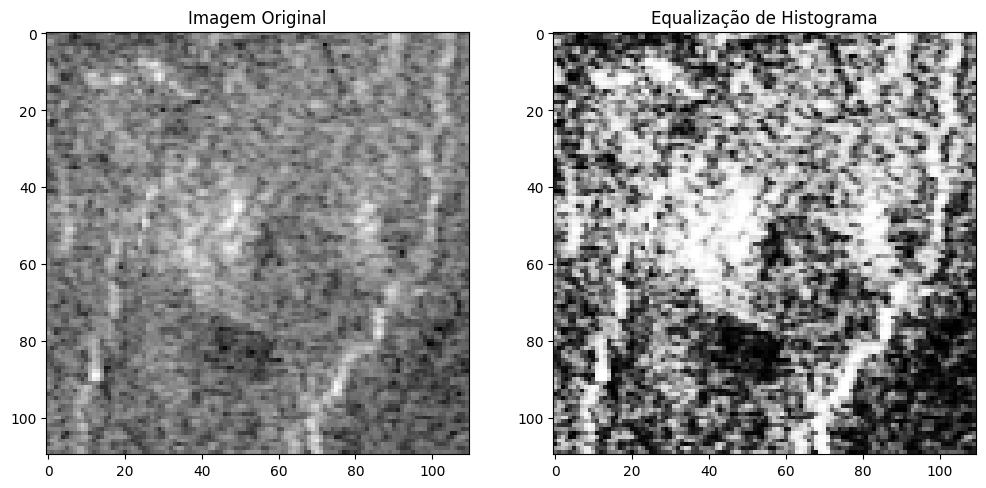

In [ ]:
print('== IMAGEM COM VULCÃO ==')

print(resp.iloc[34])
image = np.array(feat.iloc[34]).reshape((110, 110))

image_eq = exposure.equalize_hist(image)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Imagem Original")
axes[1].imshow(image_eq, cmap="gray")
axes[1].set_title("Equalização de Histograma")
plt.show()

In [ ]:
def preprocess_image(image, sigma=1):
    image_smooth = gaussian(image, sigma=sigma)

    image_eq = exposure.equalize_hist(image_smooth)
    return image_eq

def preprocess_dataset(dataset, img_shape=(110, 110)):
    processed_data = []
    for img_flat in dataset:
        image = img_flat.reshape(img_shape)
        image_processed = preprocess_image(image)
        processed_data.append(image_processed.ravel())
    return np.array(processed_data)

In [ ]:
X_train_clsf_proc = preprocess_dataset(X_train_clsf)
X_test_clsf_proc = preprocess_dataset(X_test_clsf)

### DecisionTree

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train_clsf_proc, y_train_clsf)


pred = clf.predict(X_test_clsf_proc)
pred_df = pd.DataFrame(pred)

pred_df.columns = ['Volcano?','Type','Number Volcanoes']

print(pred_df.head())

   Volcano?  Type  Number Volcanoes
0       0.0   0.0               0.0
1       0.0   0.0               0.0
2       1.0   3.0               1.0
3       0.0   0.0               0.0
4       1.0   2.0               1.0


In [ ]:
for i, col in enumerate(['Volcano?', 'Type', 'Number Volcanoes']):
    acc = accuracy_score(y_test_clsf[:, i], pred[:, i])
    print(f"Acurácia para {col}: {acc}")

Acurácia para Volcano?: 0.9198975859546452
Acurácia para Type: 0.8602779809802488
Acurácia para Number Volcanoes: 0.8884418434528164


In [ ]:
validar_com_cross_val(clf, X_train_clsf, y_train_clsf, cv=3, score = "r2");


Validação Cruzada (3-fold):
Scores: [-0.06761741 -0.0292212   0.14951484]


### KNN

In [ ]:
clf1 = KNeighborsClassifier() ; clf2 = KNeighborsClassifier() ; clf3 = KNeighborsClassifier()
clf1.fit(X_train_clsf_proc,y_train_clsf[:,0]);
clf2.fit(X_train_clsf_proc,y_train_clsf[:,1]);
clf3.fit(X_train_clsf_proc,y_train_clsf[:,2]);

pred1 = clf1.predict(X_test_clsf)
pred2 = clf2.predict(X_test_clsf)
pred3 = clf3.predict(X_test_clsf)

pred_df = pd.DataFrame({
    'Volcano?': pred1,
    'Type': pred2,
    'Number Volcanoes': pred3
})

print(pred_df.head())

   Volcano?  Type  Number Volcanoes
0       0.0   0.0               0.0
1       0.0   0.0               0.0
2       0.0   0.0               0.0
3       0.0   0.0               0.0
4       0.0   0.0               0.0


In [ ]:
for i, col in enumerate(['Volcano?', 'Type', 'Number Volcanoes']):
    acc = accuracy_score(y_test_clsf[:, i], [pred1, pred2, pred3][i])
    print(f"Acurácia para {col}: {acc}")

Acurácia para Volcano?: 0.8423555230431602
Acurácia para Type: 0.8394294074615948
Acurácia para Number Volcanoes: 0.8427212874908558


In [ ]:
validar_com_cross_val(clf1, X_train_clsf, y_train_clsf[:, 0], cv=3)
validar_com_cross_val(clf2, X_train_clsf, y_train_clsf[:, 1], cv=3)
validar_com_cross_val(clf3, X_train_clsf, y_train_clsf[:, 2], cv=3)

Validação Cruzada (3-fold):
Scores: [0.85946872 0.85983712 0.85897985]
Validação Cruzada (3-fold):
Scores: [0.85604113 0.85683669 0.85769396]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Validação Cruzada (3-fold):
Scores: [0.85861183 0.85897985 0.85812259]


#### Combinando KNN com Regressão

In [ ]:
mask_train = resp['Volcano?'] == 1
new_train_data = feat.loc[mask_train]
new_train_labels = resp.loc[mask_train, 'Radius']

mask_test = pred_df['Volcano?'] == 1
new_test_data = feat_test.loc[mask_test]
new_test_labels = resp_test.loc[mask_test, 'Radius']

X_train = new_train_data.values
y_train = new_train_labels.values

X_test = new_test_data.values
y_test = new_test_labels.values

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1000, 12100), y_train shape: (1000,)
X_test shape: (49, 12100), y_test shape: (49,)


In [ ]:
ridge_reg = Ridge()
lasso_reg = Lasso()
reg = LinearRegression()

ridge_reg.fit(X_train,y_train)
lasso_reg.fit(X_train,y_train)
reg.fit(X_train,y_train)

ridge_pred = ridge_reg.predict(X_test)
ridge_pred_df = pd.DataFrame(ridge_pred)
ridge_pred_df.columns = ['Radius']

lasso_pred = pd.DataFrame(lasso_reg.predict(X_test))
lasso_pred_df = pd.DataFrame(lasso_pred)
lasso_pred_df.columns = ['Radius']

reg_pred = pd.DataFrame(reg.predict(X_test))
reg_pred_df = pd.DataFrame(reg_pred)
reg_pred_df.columns = ['Radius']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.517e+02, tolerance: 1.352e+01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
print(f"Ridge Regression:\n{ridge_pred_df.head()}\n")
print(f"Lasso Regression:\n{lasso_pred_df.head()}\n")
print(f"Linear Regression:\n{reg_pred_df.head()}")

Ridge Regression:
      Radius
0  24.183514
1  31.962942
2  21.300602
3  16.630720
4  23.964871

Lasso Regression:
      Radius
0  26.471735
1  28.220333
2  22.352115
3  19.321066
4  35.856849

Linear Regression:
      Radius
0  24.158984
1  31.946054
2  21.314469
3  16.662291
4  23.912379


In [ ]:
avaliar_regressao(ridge_reg, y_test, ridge_pred)
avaliar_regressao(lasso_reg, y_test, lasso_pred)
avaliar_regressao(reg, y_test, reg_pred)


Avaliação do Modelo:
R²: -0.8185
MAE: 13.0693
RMSE: 15.5097


Avaliação do Modelo:
R²: -0.6914
MAE: 12.0386
RMSE: 14.9583


Avaliação do Modelo:
R²: -0.8183
MAE: 13.0707
RMSE: 15.5091



In [ ]:
regressao = [ridge_pred_df,lasso_pred_df,reg_pred_df]

In [ ]:
complete_pred_DTC = []
base_pred_df = pred_df.copy()
base_pred_df['Radius'] = [0 for _ in range(2734)]
cols = ['Volcano?', 'Type', 'Radius', 'Number Volcanoes']
base_pred_df = base_pred_df[cols]

for reg in regressao:
    radius_values = reg['Radius'].tolist()
    new_pred_df = base_pred_df.copy()
    new_pred_df['Radius'] = new_pred_df.apply(lambda row: fill_radius(row, radius_values), axis=1)
    complete_pred_DTC.append(new_pred_df)

In [ ]:
print(f"DecisionTree + Ridge Regression:\n{complete_pred_DTC[0].head()}\n")
print(f"DecisionTree + Lasso Regression:\n{complete_pred_DTC[1].head()}\n")
print(f"DecisionTree + Linear Regression:\n{complete_pred_DTC[2].head()}")

DecisionTree + Ridge Regression:
   Volcano?  Type     Radius  Number Volcanoes
0       0.0   0.0   0.000000               0.0
1       0.0   0.0   0.000000               0.0
2       1.0   0.0  24.183514               1.0
3       0.0   0.0   0.000000               0.0
4       0.0   0.0   0.000000               0.0

DecisionTree + Lasso Regression:
   Volcano?  Type     Radius  Number Volcanoes
0       0.0   0.0   0.000000               0.0
1       0.0   0.0   0.000000               0.0
2       1.0   0.0  26.471735               1.0
3       0.0   0.0   0.000000               0.0
4       0.0   0.0   0.000000               0.0

DecisionTree + Linear Regression:
   Volcano?  Type     Radius  Number Volcanoes
0       0.0   0.0   0.000000               0.0
1       0.0   0.0   0.000000               0.0
2       1.0   0.0  24.158984               1.0
3       0.0   0.0   0.000000               0.0
4       0.0   0.0   0.000000               0.0


In [ ]:
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [ ]:
def resize_images(data, new_size=(80, 80)):
    resized_data = []
    for img in data:
        img_resized = resize(img.reshape(110, 110), new_size, anti_aliasing=True)
        resized_data.append(img_resized)
    return np.array(resized_data)

print("Redimensionando as imagens para 80x80...")
feat_resized = resize_images(np.array(feat))

print(f"Formato das imagens após redimensionamento: {feat_resized.shape}")

feat_resized_flat = feat_resized.reshape(len(feat_resized), -1)

X_train_clsf, X_test_clsf, y_train_clsf, y_test_clsf = train_test_split(
    feat_resized_flat, resp, test_size=0.2, random_state=42, stratify=resp
)

print(f"Formato X_train_clsf: {X_train_clsf.shape}")
print(f"Formato X_test_clsf: {X_test_clsf.shape}")
print(f"Formato y_train_clsf: {y_train_clsf.shape}")
print(f"Formato y_test_clsf: {y_test_clsf.shape}")

Redimensionando as imagens para 80x80...
Formato das imagens após redimensionamento: (7000, 80, 80)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.